# CNN AE

In [ ]:
# cnn autoncoder model
import tensorflow as tf
from keras.layers import Input, Dense, Dropout
from keras.models import Model, Sequential
from keras import regularizers
from keras.layers import Input, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, AveragePooling1D,Reshape,UpSampling1D
from keras.models import Model, Sequential
from keras import initializers
#CNN autoencoder
def CNN_encoder(input,dims):
  ## encoding part
  initializer = tf.keras.initializers.HeNormal()
  layer = Conv1D(64, kernel_size=3, padding="same", activation="relu")(input)
  layer = MaxPooling1D(pool_size=2)(layer)
  layer=Dropout(0.25)(layer)
  layer = Conv1D(128, kernel_size=3, padding="same", activation="relu")(layer)
  layer = MaxPooling1D(pool_size=2)(layer)
  layer=Dropout(0.25)(layer)
  layer = Conv1D(256, kernel_size=3, padding="same", activation="relu")(layer)
  layer = MaxPooling1D(pool_size=2)(layer)
  layer=Dropout(0.25)(layer)
  layer = Conv1D(512, kernel_size=3, padding="same", activation="relu")(layer)
  layer = MaxPooling1D(pool_size=2)(layer)
  layer=Dropout(0.25)(layer)

  layer = Flatten()(layer)
  encoded = Dense(dims, activation="relu")(layer)
  return encoded

def CNN_decoder(encoded):
  ## decoding part
  initializer = tf.keras.initializers.HeNormal()
  layer = Dense(250* 512, activation="relu", use_bias=False)(encoded)
  layer = Reshape((250, 512))(layer)
  layer = Conv1D(512, kernel_size=3, padding="same", activation="relu")(layer)
  layer = UpSampling1D(size=2)(layer)
  layer = Conv1D(256, kernel_size=3, padding="same", activation="relu")(layer)
  layer = UpSampling1D(size=2)(layer)
  layer = Conv1D(128, kernel_size=3, padding="same", activation="relu")(layer)
  layer = UpSampling1D()(layer)
  layer = Conv1D(64, kernel_size=3, padding="same", activation="relu")(layer)
  layer = UpSampling1D()(layer)
  decoded = Conv1D(1, kernel_size=3, padding="same", activation="sigmoid")(layer)

  return decoded
def CAE_model(Train_X,dims):
  CNNinput_layer = Input(shape=(Train_X.shape[1],1))
  cnn_x = CNN_encoder(CNNinput_layer,dims)
  cnn_x_hat = CNN_decoder(cnn_x)
  CNNmodel = Model(CNNinput_layer, cnn_x_hat)
  CNN_enconder = Model(CNNinput_layer, cnn_x, name="encoder")
  return CNNmodel,CNN_enconder

def CAE_hiddenrepresentation(data,method_enconder):
        """Transform the vector.
        From original dimensions to latent dimensions.
        Parameters
        ----------
        data : array-like  (n_samples, n_features)
            The input data to use in transform process.
        Returns
        -------
        _ : array-like  (n_samples, value_encoding_dim)
            The data transformed to latent dimensions format.
        """
        return method_enconder.predict(data)
def CNNextractrep(model):
  hidden_representation = Sequential()
  hidden_representation.add(model.layers[0])
  hidden_representation.add(model.layers[1])
  hidden_representation.add(model.layers[2])
  hidden_representation.add(model.layers[3])
  hidden_representation.add(model.layers[4])
  hidden_representation.add(model.layers[5])
  hidden_representation.add(model.layers[6])
  hidden_representation.add(model.layers[7])
  hidden_representation.add(model.layers[8])
  hidden_representation.add(model.layers[9])
  hidden_representation.add(model.layers[10])
  hidden_representation.add(model.layers[11])
  hidden_representation.add(model.layers[12])
  hidden_representation.add(model.layers[13])
  hidden_representation.add(model.layers[14])
  return hidden_representation

# loading and preprocessing

In [ ]:
!pip install ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.33 s (started: 2021-08-20 18:23:04 +00:00)


In [ ]:
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
from sklearn import preprocessing 
from sklearn import svm
from tensorflow import keras
from sklearn.metrics import plot_confusion_matrix
from keras.callbacks import History
from google.colab import files
from sklearn.metrics import confusion_matrix
import re
from imblearn.under_sampling import ClusterCentroids
sns.set(style="whitegrid")
np.random.seed(203)
encodding_dim= 700
epoch_num=500
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def load_data(info_test,info_train,info_dev):
  local_path='/content/drive/My Drive/.../down sampled 3'#RAW AUDIO SAMPLES
  Train_MList = []
  Test_MList = []
  Dev_MList = []
  Train_FList = []
  Test_FList = []
  Dev_FList = []
  for filename in os.listdir(local_path):
    if filename.endswith('.csv'): 
        file_path=local_path+'/'+filename
        File = pd.read_csv(file_path)
        nameid= re.sub('\.csv$', '',  filename)
        nameid=int(nameid)
        if info_train[info_train['Participant_ID']==nameid].index.tolist():
          listindex=info_train[info_train['Participant_ID']==nameid].index.tolist()
          temp = info_train.iloc[listindex]
          index = list(temp.index)
          gender = temp.loc[index[0], 'Gender']
          label = temp.loc[index[0], 'PHQ8_Binary']
          File = File.assign(Class=label)
          if gender==1 :#if male 
            Train_MList.append(File)
          else: #female
            Train_FList.append(File)
        if info_test[info_test['Participant_ID']==nameid].index.tolist():
          listindex=info_test[info_test['Participant_ID']==nameid].index.tolist()
          temp = info_test.iloc[listindex]
          index = list(temp.index)
          gender = temp.loc[index[0], 'Gender']
          label = temp.loc[index[0], 'PHQ_Binary']
          File = File.assign(Class=label)
          if gender==1 :#if male 
            Test_MList.append(File)
          else: #female
            Test_FList.append(File) 
        if info_dev[info_dev['Participant_ID']==nameid].index.tolist():
          listindex=info_dev[info_dev['Participant_ID']==nameid].index.tolist()
          temp = info_dev.iloc[listindex]
          index = list(temp.index)
          gender = temp.loc[index[0], 'Gender']
          label = temp.loc[index[0], 'PHQ8_Binary']
          File = File.assign(Class=label)
          if gender==1 :#if male 
            Dev_MList.append(File)
          else: #female
            Dev_FList.append(File) 
  new_Train_F = pd.concat(Train_FList)
  new_Test_F = pd.concat(Test_FList)
  new_Dev_F = pd.concat(Dev_FList)    
  new_Train_M = pd.concat(Train_MList)
  new_Test_M = pd.concat(Test_MList)
  new_Dev_M = pd.concat(Dev_MList)  
  return new_Train_F,new_Test_F,new_Dev_F,new_Train_M,new_Test_M,new_Dev_M

def clusterin_resampling (Train_F,Test_F,Dev_F,Train_M,Test_M,Dev_M):
  #This is a not used function which was used for resampling male and female data
  colnames=list(Train_F.columns)
  x = Train_F.drop(["Class"], axis=1)
  y = Train_F["Class"].values
  cc = ClusterCentroids(random_state=42)
  X_res, y_res = cc.fit_sample(x, y)
  wholedata_train=np.concatenate((X_res, y_res[:,None]), axis=1)
  new_train_F = pd.DataFrame(data = wholedata_train,columns = colnames) 

  x = Dev_F.drop(["Class"], axis=1)
  y = Dev_F["Class"].values
  cc = ClusterCentroids(random_state=42)
  X_res, y_res = cc.fit_sample(x, y)
  wholedata_dev=np.concatenate((X_res, y_res[:,None]), axis=1)
  new_dev_F = pd.DataFrame(data = wholedata_dev,columns = colnames) 

  x = Test_F.drop(["Class"], axis=1)
  y = Test_F["Class"].values
  cc = ClusterCentroids(random_state=42)
  X_res, y_res = cc.fit_sample(x, y)
  wholedata_test=np.concatenate((X_res, y_res[:,None]), axis=1)
  new_test_F = pd.DataFrame(data = wholedata_test,columns = colnames) 
 
  x = Train_M.drop(["Class"], axis=1)
  y = Train_M["Class"].values
  cc = ClusterCentroids(random_state=42)
  X_res, y_res = cc.fit_sample(x, y)
  wholedata_train=np.concatenate((X_res, y_res[:,None]), axis=1)
  new_train_M = pd.DataFrame(data = wholedata_train,columns = colnames) 

  x = Dev_M.drop(["Class"], axis=1)
  y = Dev_M["Class"].values
  cc = ClusterCentroids(random_state=42)
  X_res, y_res = cc.fit_sample(x, y)
  wholedata_dev=np.concatenate((X_res, y_res[:,None]), axis=1)
  new_dev_M = pd.DataFrame(data = wholedata_dev,columns = colnames) 

  x = Test_M.drop(["Class"], axis=1)
  y = Test_M["Class"].values
  cc = ClusterCentroids(random_state=42)
  X_res, y_res = cc.fit_sample(x, y)
  wholedata_test=np.concatenate((X_res, y_res[:,None]), axis=1)
  new_test_M = pd.DataFrame(data = wholedata_test,columns = colnames) 
  return new_train_F, new_dev_F, new_test_F,new_train_M, new_dev_M, new_test_M
#read train data and test data


#to see female or male
info_train=pd.read_csv('/content/drive/My Drive/.../train_split_Depression_AVEC2017.csv')
info_dev=pd.read_csv('/content/drive/My Drive/.../dev_split_Depression_AVEC2017.csv')
info_test=pd.read_csv('/content/drive/My Drive/.../full_test_split.csv')

Train_F,Test_F,Dev_F,Train_M,Test_M,Dev_M=load_data(info_test,info_train,info_dev)


In [ ]:
new_Train_total = Train_F.append(Train_M)
new_Test_total = Test_F.append(Test_M)
new_Dev_total = Dev_F.append(Dev_M)
print(new_Train_total.shape)
print(new_Test_total.shape)
print(new_Dev_total.shape)

(14400, 4001)
(5700, 4001)
(3900, 4001)


In [ ]:
#This is the part used for clustering the data
colnames=list(Train_F.columns)
x = new_Train_total.drop(["Class"], axis=1)
y = new_Train_total["Class"].values

cc = ClusterCentroids(random_state=42)
X_res, y_res = cc.fit_sample(x, y)
wholedata_train=np.concatenate((X_res, y_res[:,None]), axis=1)
new_Train_total = pd.DataFrame(data = wholedata_train,columns = colnames) 


x = new_Dev_total.drop(["Class"], axis=1)
y = new_Dev_total["Class"].values

cc = ClusterCentroids(random_state=42)
X_res, y_res = cc.fit_sample(x, y)
wholedata_dev=np.concatenate((X_res, y_res[:,None]), axis=1)
new_Dev_total = pd.DataFrame(data = wholedata_dev,columns = colnames) 


x = new_Test_total.drop(["Class"], axis=1)
y = new_Test_total["Class"].values

cc = ClusterCentroids(random_state=42)
X_res, y_res = cc.fit_sample(x, y)
wholedata_test=np.concatenate((X_res, y_res[:,None]), axis=1)
new_Test_total = pd.DataFrame(data = wholedata_test,columns = colnames) 


In [ ]:
'''
#just uncomment this part to save clustered data
from google.colab import files

#new_Train_total.to_csv('Train_clustercentroid.csv')
#files.download('Train_clustercentroid.csv')

#new_Test_total.to_csv('Test_clustercentroid.csv')
#files.download('Test_clustercentroid.csv')
#new_Dev_total.to_csv('Dev_clustercentroid.csv')
#files.download('Dev_clustercentroid.csv')
'''

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
'''
#if you want to use your saved files for clustered data, uncomment this
new_Train_total1=pd.read_csv('/content/drive/My Drive/.../clusteredData/Train_clustercentroid.csv')
new_Test_total1=pd.read_csv('/content/drive/My Drive/.../clusteredData/Test_clustercentroid.csv')
new_Dev_total1=pd.read_csv('/content/drive/My Drive/.../clusteredData/Dev_clustercentroid.csv')
new_Test_total = new_Test_total1.iloc[: , 1:]
new_Train_total = new_Train_total1.iloc[: , 1:]
new_Dev_total = new_Dev_total1.iloc[: , 1:]

'''

In [ ]:
#---------before training perform Max-Min scalling
Scaler=preprocessing.MinMaxScaler()
x_train = new_Train_total.drop(["Class"], axis=1)
y_train = new_Train_total["Class"].values

x_scaled_train = Scaler.fit_transform(x_train.values)#MinMax scalling Train data
x_nondep_train, x_dep_train = x_scaled_train[y_train == 0], x_scaled_train[y_train == 1]
#---------before validating perform Max-Min scalling
x_val = new_Dev_total.drop(["Class"], axis=1)
y_val = new_Dev_total["Class"].values

x_scaled_val = Scaler.transform(x_val.values)#MinMax scalling Train data
x_nondep_val, x_dep_val = x_scaled_val[y_val == 0], x_scaled_val[y_val == 1]
#---------before testing perform Max-Min scalling
x_test = new_Test_total.drop(["Class"], axis=1)
y_test = new_Test_total["Class"].values

x_scaled_test = Scaler.transform(x_test.values)#MinMax scalling Train data
x_nondep_test, x_dep_test = x_scaled_test[y_test== 0], x_scaled_test[y_test == 1]

# CAE training and testing

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 4000, 64)          256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2000, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 2000, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2000, 128)         24704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1000, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000, 128)         0     

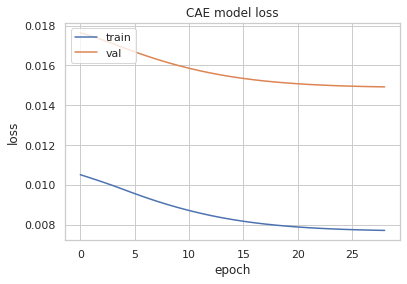

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 4000, 64)          256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2000, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 2000, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2000, 128)         24704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1000, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000, 128)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1000, 256)         9

In [ ]:
epoch_num=500
Batchsize=32
#training
save_dir = '/content/drive/My Drive/.../'
CNN_autoencoder,CNN_latent=CAE_model(x_scaled_train,encodding_dim)
CNN_autoencoder.compile(optimizer='adadelta', loss='mse')#specifying a loss, metrics, and an optimizer
print(CNN_autoencoder.summary())

#create call backs
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+'modeltotalCAE.h5', save_best_only=True, monitor='val_loss', verbose=1, mode='min')
# define our early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    min_delta=0.00005,
    patience=3,
    verbose=1, 
    mode='min',
    restore_best_weights=True)
callbacks_list = [early_stop, checkpoint]## This saves the best model
# FIT THE MODEL
#--------------------------CNN autoencoder-------------------------
history=CNN_autoencoder.fit(x_scaled_train, x_scaled_train, 
                batch_size = Batchsize, epochs = epoch_num, 
                shuffle=True, validation_data = (x_scaled_val, x_scaled_val),verbose=1,callbacks=callbacks_list);
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CAE model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# LOAD BEST MODEL to evaluate the performance of the model
CNN_autoencoder.load_weights("/content/drive/My Drive/.../modeltotalCAE.h5")

#------find the new represenation of Train data
LatentRepresenation=CNNextractrep(CNN_autoencoder)
print(LatentRepresenation.summary())

x_nondep_training_data=x_nondep_train.copy()
x_dep_training_data=x_dep_train.copy()

x_nondep_training_data = np.expand_dims(x_nondep_training_data, axis=2)
x_dep_training_data = np.expand_dims(x_dep_training_data, axis=2)
Nondep_hid_rep_Train =LatentRepresenation.predict(x_nondep_training_data)
Dep_hid_rep_Train =LatentRepresenation.predict(x_dep_training_data)

rep_x_Train = np.append(Nondep_hid_rep_Train, Dep_hid_rep_Train, axis = 0)#total latent representation
y_n = np.zeros(Nondep_hid_rep_Train.shape[0])
y_d = np.ones(Dep_hid_rep_Train.shape[0])
rep_y_Train = np.append(y_n, y_d)#Total labels

x_nondep_validation_data=x_nondep_val.copy()
x_dep_validation_data=x_dep_val.copy()

x_nondep_validation_data= np.expand_dims(x_nondep_validation_data, axis=2)
x_dep_validation_data = np.expand_dims(x_dep_validation_data, axis=2)
Nondep_hid_rep_Valid =LatentRepresenation.predict(x_nondep_validation_data)
Dep_hid_rep_Valid =LatentRepresenation.predict(x_dep_validation_data)

rep_x_Valid = np.append(Nondep_hid_rep_Valid , Dep_hid_rep_Valid, axis = 0)#total latent representation
y_n_valid = np.zeros(Nondep_hid_rep_Valid .shape[0])
y_d_valid = np.ones(Dep_hid_rep_Valid.shape[0])
rep_y_Valid = np.append(y_n_valid, y_d_valid)#Total labels

#-------------------------------evaluate model
#  SVM classifier on trained latent space
from sklearn import svm
clf = svm.SVC(kernel='rbf')#change gamma="0.001" to scale and c if you want
clf.fit(rep_x_Train, rep_y_Train)
pred_y=clf.predict(rep_x_Valid)
print ("")
print ("Classification Report: SVM on latent")
print (classification_report(rep_y_Valid, pred_y))
print ("")
print ("Accuracy Score: ", accuracy_score(rep_y_Valid, pred_y))

cm = confusion_matrix(rep_y_Valid, pred_y)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm.diagonal()
print ("")
print(cm.diagonal())

tf.keras.backend.clear_session()


Classification Report: SVM on latent
              precision    recall  f1-score   support

         0.0       0.70      0.72      0.71      1650
         1.0       0.71      0.68      0.70      1650

    accuracy                           0.70      3300
   macro avg       0.70      0.70      0.70      3300
weighted avg       0.70      0.70      0.70      3300


Accuracy Score:  0.7033333333333334

[0.72424242 0.68242424]


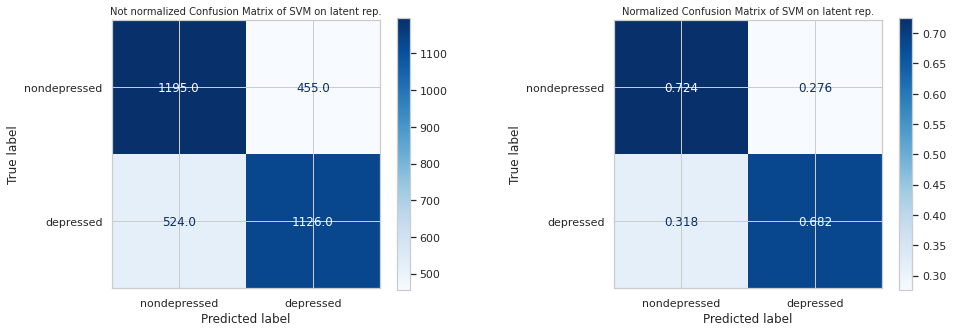

In [ ]:
#testing

whole_train_x=np.concatenate((x_scaled_train, x_scaled_val), axis=0)
whole_train_y=np.concatenate([y_train, y_val])
x_nondep_train, x_dep_train = whole_train_x[whole_train_y == 0], whole_train_x[whole_train_y == 1]
#------find the new represenation of Train and Dev data as new train data
LatentRepresenation=CNNextractrep(CNN_autoencoder)

x_nondep_train = np.expand_dims(x_nondep_train, axis=2)
x_dep_train = np.expand_dims(x_dep_train, axis=2)

Nondep_hid_rep_Train =LatentRepresenation.predict(x_nondep_train)
Dep_hid_rep_Train =LatentRepresenation.predict(x_dep_train)

rep_x_Train = np.append(Nondep_hid_rep_Train, Dep_hid_rep_Train, axis = 0)#total latent representation
y_n = np.zeros(Nondep_hid_rep_Train.shape[0])
y_d = np.ones(Dep_hid_rep_Train.shape[0])
rep_y_Train = np.append(y_n, y_d)#Total labels


x_nondep_test = np.expand_dims(x_nondep_test, axis=2)
x_dep_test = np.expand_dims(x_dep_test, axis=2)
Nondep_hid_rep_Valid =LatentRepresenation.predict(x_nondep_test)
Dep_hid_rep_Valid =LatentRepresenation.predict(x_dep_test)

rep_x_Valid = np.append(Nondep_hid_rep_Valid , Dep_hid_rep_Valid, axis = 0)#total latent representation
y_n_valid = np.zeros(Nondep_hid_rep_Valid.shape[0])
y_d_valid = np.ones(Dep_hid_rep_Valid.shape[0])
rep_y_Valid = np.append(y_n_valid, y_d_valid)#Total labels

#tsne_plot(rep_x_Train, rep_y_Train, "original data with SVM")
#-------------------------------evaluate model
#  SVM classifier on trained latent space
from sklearn import svm
clf = svm.SVC(kernel='rbf')#change gamma="0.001" to scale and c if you want
clf.fit(rep_x_Train, rep_y_Train)
pred_y=clf.predict(rep_x_Valid)
print ("")
print ("Classification Report: SVM on latent")
print (classification_report(rep_y_Valid, pred_y))
print ("")
print ("Accuracy Score: ", accuracy_score(rep_y_Valid, pred_y))
cm = confusion_matrix(rep_y_Valid, pred_y)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm.diagonal()
print ("")
print(cm.diagonal())
#plot
fig, axes = plt.subplots(ncols=2,figsize=(15, 5))
ax1, ax2 = axes
class_names=['nondepressed','depressed']
plot_confusion_matrix(clf, rep_x_Valid, rep_y_Valid,ax=ax1 ,display_labels=class_names,
                                 cmap=plt.cm.Blues,values_format = '.1f') 
ax1.set_title('Not normalized Confusion Matrix of SVM on latent rep.',fontsize=10)

plot_confusion_matrix(clf, rep_x_Valid, rep_y_Valid,ax=ax2 ,display_labels=class_names,
                                 cmap=plt.cm.Blues,values_format = '.3f',normalize='true')
ax2.set_title('Normalized Confusion Matrix of SVM on latent rep.',fontsize=10) 
plt.subplots_adjust(wspace=0.50)
#plt.savefig("SVM_lat_AE.png")
#files.download("SVM_lat_AE.png")
plt.show()

# checking saved model

In [ ]:
CNN_autoencoder,CNN_latent=CAE_model(x_scaled_train,encodding_dim)
CNN_autoencoder.load_weights("/content/drive/My Drive/.../modeltotalCAE.h5")
print(CNN_autoencoder.summary())


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 4000, 64)          256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2000, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 2000, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2000, 128)         24704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1000, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000, 128)         0     


Classification Report: SVM on latent
              precision    recall  f1-score   support

         0.0       0.70      0.72      0.71      1650
         1.0       0.71      0.69      0.70      1650

    accuracy                           0.70      3300
   macro avg       0.70      0.70      0.70      3300
weighted avg       0.70      0.70      0.70      3300


Accuracy Score:  0.703939393939394

[0.71878788 0.68909091]


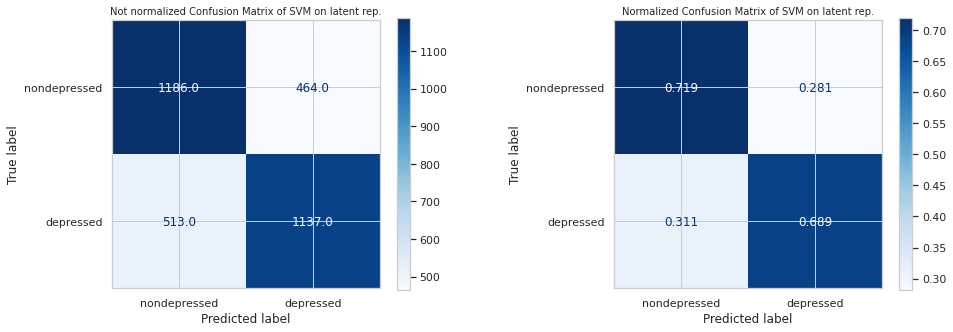

In [ ]:

#testing

whole_train_x=np.concatenate((x_scaled_train, x_scaled_val), axis=0)
whole_train_y=np.concatenate([y_train, y_val])
x_nondep_train, x_dep_train = whole_train_x[whole_train_y == 0], whole_train_x[whole_train_y == 1]
#------find the new represenation of Train and Dev data as new train data
LatentRepresenation=CNNextractrep(CNN_autoencoder)

x_nondep_train = np.expand_dims(x_nondep_train, axis=2)
x_dep_train = np.expand_dims(x_dep_train, axis=2)

Nondep_hid_rep_Train =LatentRepresenation.predict(x_nondep_train)
Dep_hid_rep_Train =LatentRepresenation.predict(x_dep_train)

rep_x_Train = np.append(Nondep_hid_rep_Train, Dep_hid_rep_Train, axis = 0)#total latent representation
y_n = np.zeros(Nondep_hid_rep_Train.shape[0])
y_d = np.ones(Dep_hid_rep_Train.shape[0])
rep_y_Train = np.append(y_n, y_d)#Total labels


x_nondep_test = np.expand_dims(x_nondep_test, axis=2)
x_dep_test = np.expand_dims(x_dep_test, axis=2)
Nondep_hid_rep_Valid =LatentRepresenation.predict(x_nondep_test)
Dep_hid_rep_Valid =LatentRepresenation.predict(x_dep_test)

rep_x_Valid = np.append(Nondep_hid_rep_Valid , Dep_hid_rep_Valid, axis = 0)#total latent representation
y_n_valid = np.zeros(Nondep_hid_rep_Valid.shape[0])
y_d_valid = np.ones(Dep_hid_rep_Valid.shape[0])
rep_y_Valid = np.append(y_n_valid, y_d_valid)#Total labels

#-------------------------------evaluate model
#  SVM classifier on trained latent space
from sklearn import svm
clf = svm.SVC(kernel='rbf')#change gamma="0.001" to scale and c if you want
clf.fit(rep_x_Train, rep_y_Train)
pred_y=clf.predict(rep_x_Valid)
print ("")
print ("Classification Report: SVM on latent")
print (classification_report(rep_y_Valid, pred_y))
print ("")
print ("Accuracy Score: ", accuracy_score(rep_y_Valid, pred_y))
cm = confusion_matrix(rep_y_Valid, pred_y)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm.diagonal()
print ("")
print(cm.diagonal())
#plot
fig, axes = plt.subplots(ncols=2,figsize=(15, 5))
ax1, ax2 = axes
class_names=['nondepressed','depressed']
plot_confusion_matrix(clf, rep_x_Valid, rep_y_Valid,ax=ax1 ,display_labels=class_names,
                                 cmap=plt.cm.Blues,values_format = '.1f') 
ax1.set_title('Not normalized Confusion Matrix of SVM on latent rep.',fontsize=10)

plot_confusion_matrix(clf, rep_x_Valid, rep_y_Valid,ax=ax2 ,display_labels=class_names,
                                 cmap=plt.cm.Blues,values_format = '.3f',normalize='true')
ax2.set_title('Normalized Confusion Matrix of SVM on latent rep.',fontsize=10) 
plt.subplots_adjust(wspace=0.50)
#plt.savefig("SVM_lat_AE.png")
#files.download("SVM_lat_AE.png")
plt.show()


Classification Report: Mlp  on latent
              precision    recall  f1-score   support

         0.0       0.71      0.65      0.68      1650
         1.0       0.68      0.73      0.70      1650

    accuracy                           0.69      3300
   macro avg       0.69      0.69      0.69      3300
weighted avg       0.69      0.69      0.69      3300


Accuracy Score:  0.6921212121212121

[0.65333333 0.73090909]


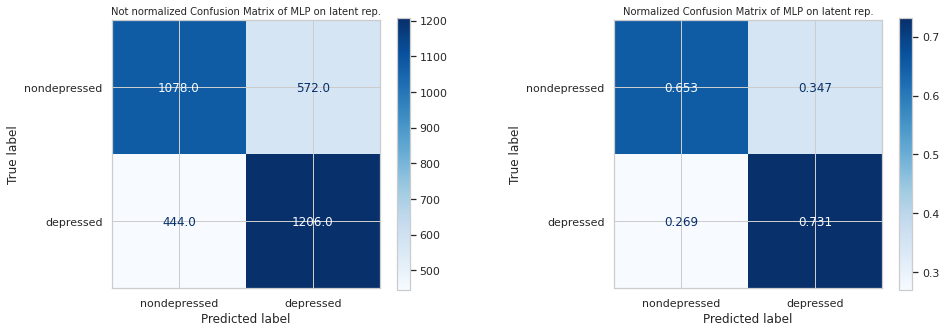

In [ ]:

#-------------------------------evaluate model
#  MLP classifier on trained latent space
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=1,hidden_layer_sizes=(128,100,),activation='logistic', max_iter=100).fit(rep_x_Train, rep_y_Train)
pred_y=clf.predict(rep_x_Valid)
print ("")
print ("Classification Report: Mlp  on latent")
print (classification_report(rep_y_Valid, pred_y))
print ("")
print ("Accuracy Score: ", accuracy_score(rep_y_Valid, pred_y))
cm = confusion_matrix(rep_y_Valid, pred_y)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm.diagonal()
print ("")
print(cm.diagonal())
#plot
fig, axes = plt.subplots(ncols=2,figsize=(15, 5))
ax1, ax2 = axes
class_names=['nondepressed','depressed']
plot_confusion_matrix(clf, rep_x_Valid, rep_y_Valid,ax=ax1 ,display_labels=class_names,
                                 cmap=plt.cm.Blues,values_format = '.1f') 
ax1.set_title('Not normalized Confusion Matrix of MLP on latent rep.',fontsize=10)

plot_confusion_matrix(clf, rep_x_Valid, rep_y_Valid,ax=ax2 ,display_labels=class_names,
                                 cmap=plt.cm.Blues,values_format = '.3f',normalize='true')
ax2.set_title('Normalized Confusion Matrix of MLP on latent rep.',fontsize=10) 
plt.subplots_adjust(wspace=0.50)
plt.show()